# Data Analysis of the Ford GoBike's trip data

Exploring user types Customer and Subscribers prefered weekdays for bike rides and the most common duration of bike trips.

## Investigation Overview

Bike rental trips investigation on prefered day of week.

## Dataset Overview

The data consist of over 2 million bike trips collected between january 2018 and february 2019. The attributes include start and stop station with date and time, user type. No data points was removed from the downloaded from the Ford GoBike's trip data for public use.

In [1]:
import requests
import os, sys
import pandas as pd
import numpy as np
import zipfile
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
DATA_DIR = 'data'
IMAGES_DIR = 'images'

def ensure_dir(file_path=IMAGES_DIR):
    """
    Ensure directory exists or create it.
    :param file_path: directory path
    :return: 
    """
    if not os.path.exists(file_path):
        os.makedirs(file_path)


# load data source files and make one DataFrame
tripdata_files = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv') and os.path.isfile(os.path.join(DATA_DIR, file))]
dataframes = [pd.read_csv(os.path.join(DATA_DIR, file)) for file in tripdata_files]

bikeshare_df = pd.concat(dataframes)
del tripdata_files
del dataframes

bikeshare_df['start_time'] = pd.to_datetime(bikeshare_df['start_time'])
bikeshare_df['end_time'] = pd.to_datetime(bikeshare_df['end_time'])
bikeshare_df['duration'] = bikeshare_df['duration_sec'].apply(lambda x: timedelta(seconds=x))
bikeshare_df['user_type'] = bikeshare_df['user_type'].astype('category')
bikeshare_df['bike_share_for_all_trip'] = bikeshare_df['bike_share_for_all_trip'].astype('category')
bikeshare_df['member_gender'].fillna('Other', inplace=True)
bikeshare_df['member_gender'] = bikeshare_df['member_gender'].astype('category')

userstart = bikeshare_df[['user_type', 'start_time', 'duration_sec']].copy()
userstart['weekday'] = userstart.start_time.dt.weekday_name


## 1. How long is the typical bike trip duration?  

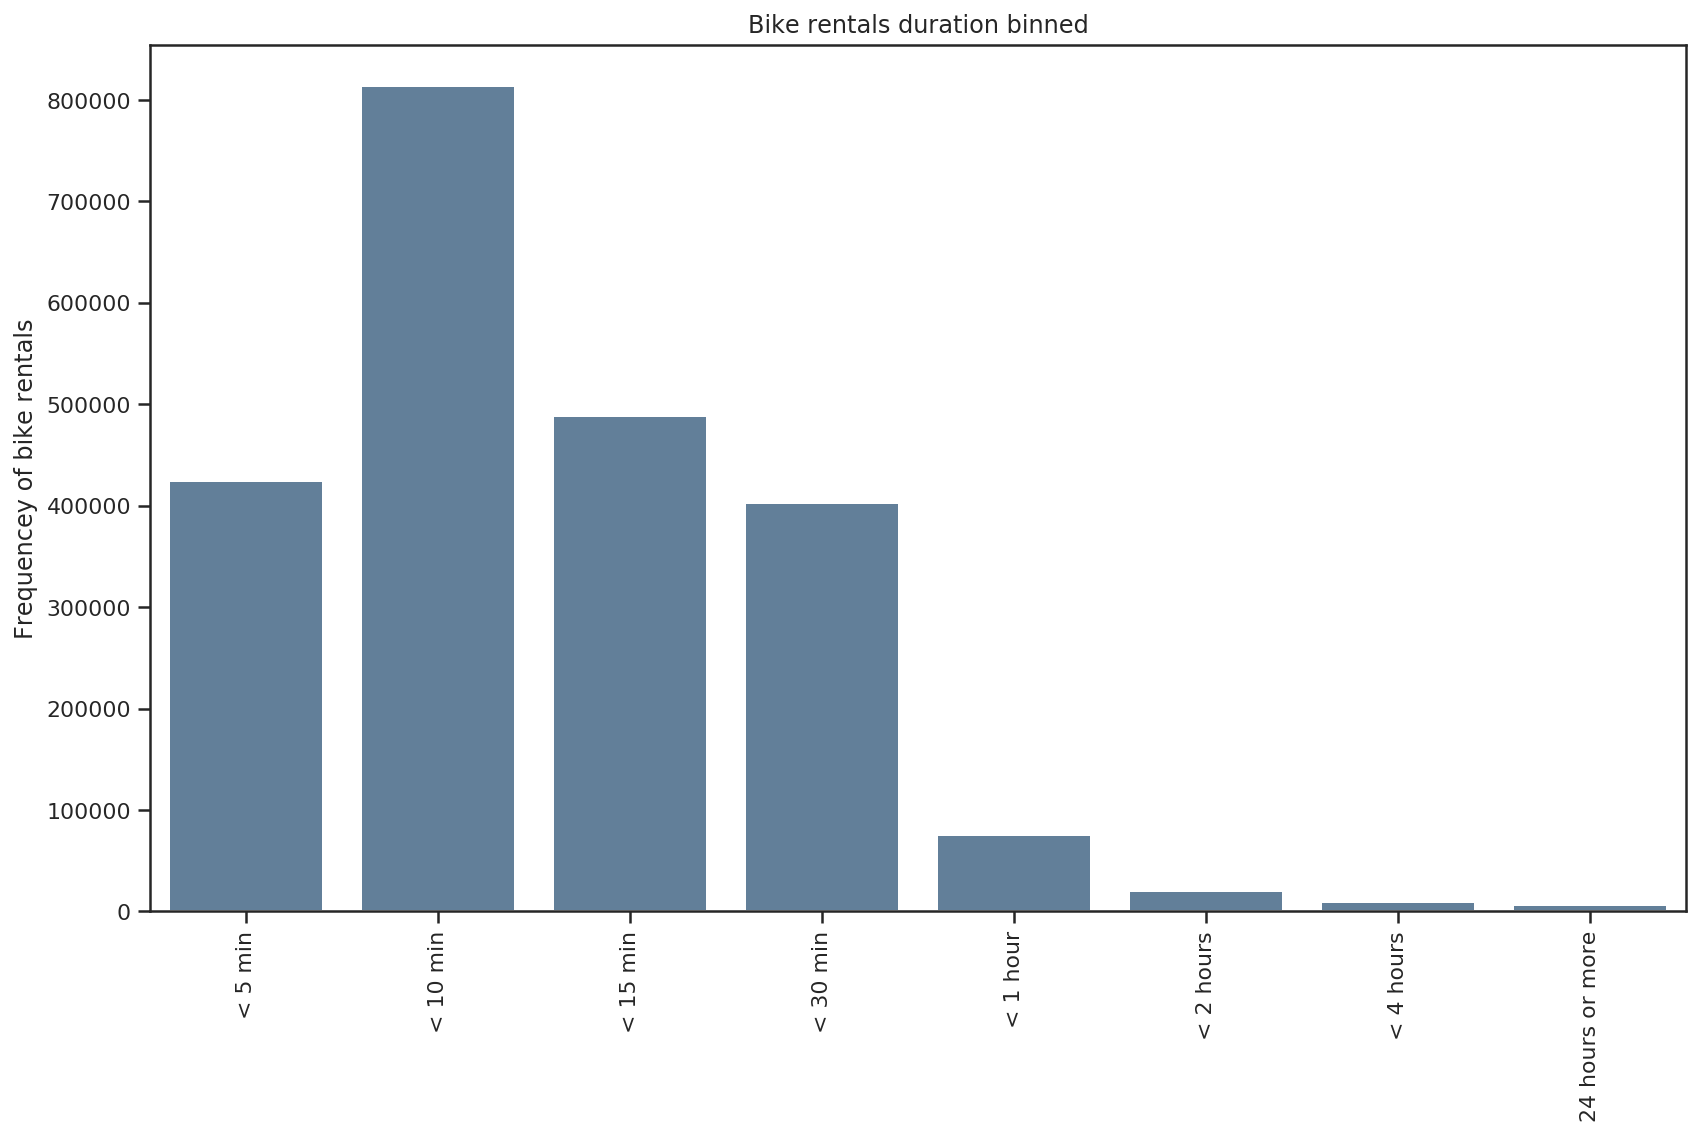

In [7]:
bins = [0, 300, 600, 900, 1800, 3600, 7200, 14400, 86400]
labels = ['< 5 min', '< 10 min', '< 15 min', '< 30 min', '< 1 hour', '< 2 hours', '< 4 hours', '24 hours or more']

duration_quartiles = pd.cut(bikeshare_df['duration_sec'], bins=bins, labels=labels)
binned_duration = duration_quartiles.value_counts(sort=False)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(binned_duration.index, binned_duration, color='steelblue', saturation=0.5, ax=ax)
ax.set(title='Bike rentals duration binned', xlabel='', ylabel='Frequencey of bike rentals')
ax.tick_params(axis='x', labelrotation=90)

ensure_dir(IMAGES_DIR)
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'bike_rental_duration.jpg'))

The bike rental duration contains some extreme values. But the most common bike rental is less than 10 minutes in lenght.

## 2. During what days of the week does bike rentals occur?  


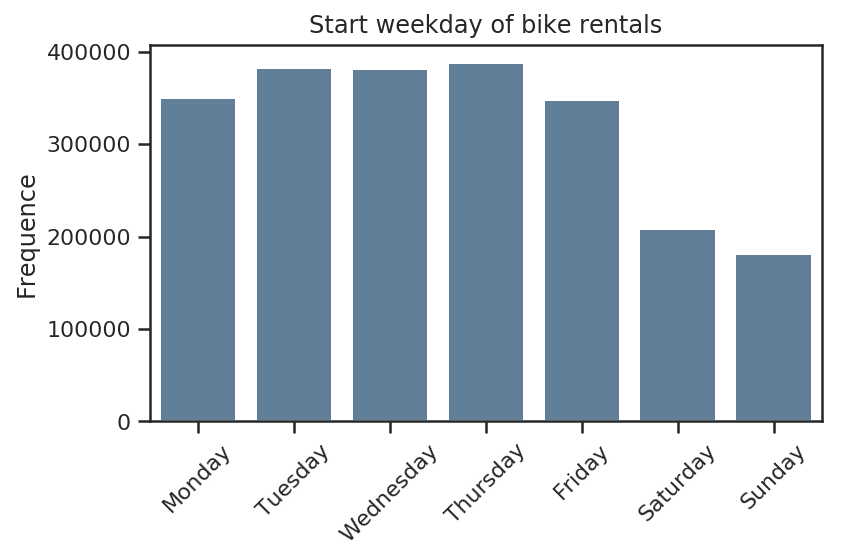

In [8]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax = sns.countplot(bikeshare_df.start_time.dt.weekday_name, 
                   order=weekday_names, 
                   color='steelblue', 
                   saturation=0.5)

ax.set(xlabel='', 
       ylabel='Frequence', 
       title='Start weekday of bike rentals')
ax.tick_params(axis='x', 
               labelrotation=45)

ensure_dir(IMAGES_DIR)
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'weekday_bike.rentals.jpg'))

Bike rentals mostly occurs on business weekdays with peek bike trips on tuesday, wednesday, and thursdays.

### Are there differences between Customer and Subscribers?

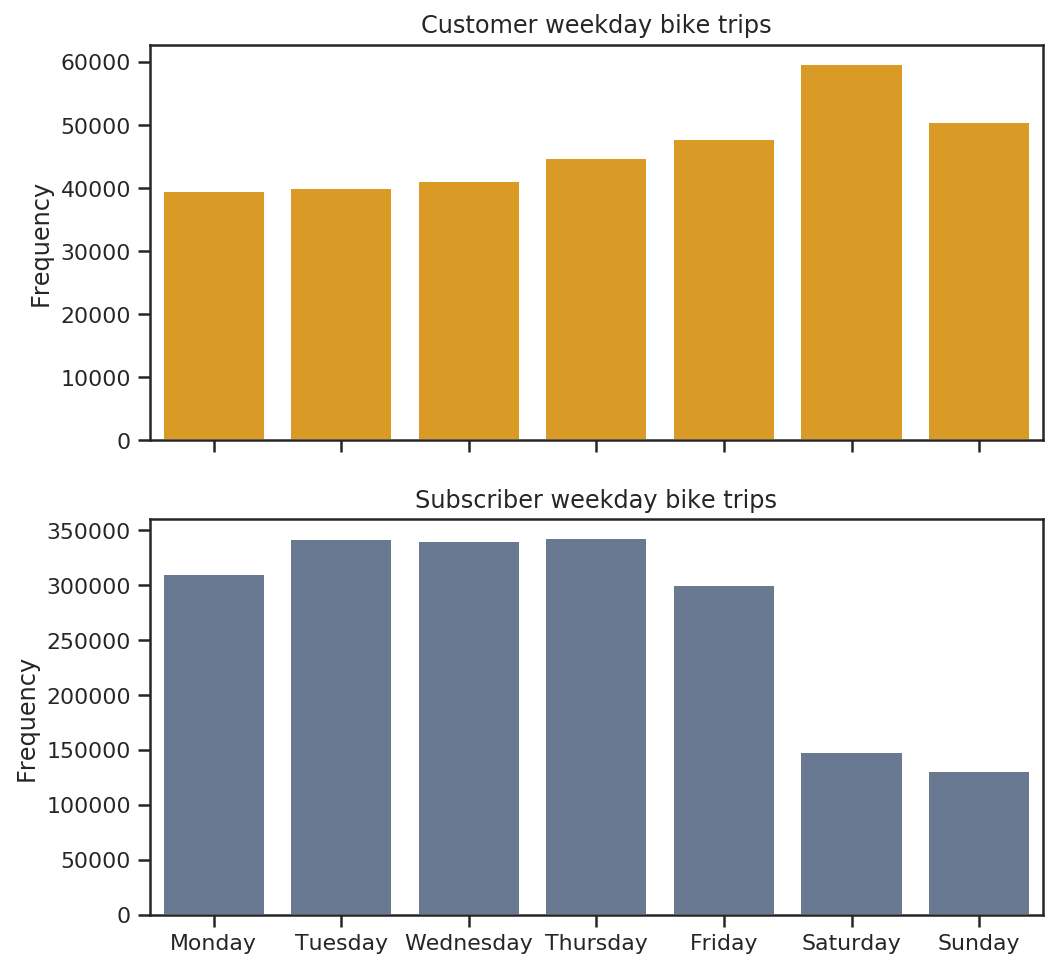

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (8, 8))

sns.countplot(x='weekday', 
              data=userstart[userstart.user_type == 'Customer'], 
              order=weekday_names, 
              color='orange', 
              saturation=0.7, 
              ax=ax1)
ax1.set(xlabel='', ylabel='Frequency', title='Customer weekday bike trips')

sns.countplot(x='weekday', 
                   data=userstart[userstart.user_type == 'Subscriber'], 
                   order=weekday_names, 
                   color='b', 
                   saturation=0.4, 
                   ax=ax2)
ax2.set(xlabel='', ylabel='Frequency', title='Subscriber weekday bike trips');

There are two different user types Customer and Subscribers.

## 3. Same station start and end rentals

Is there a different weekday rental pattern when the same station is used for both start and end of trip?

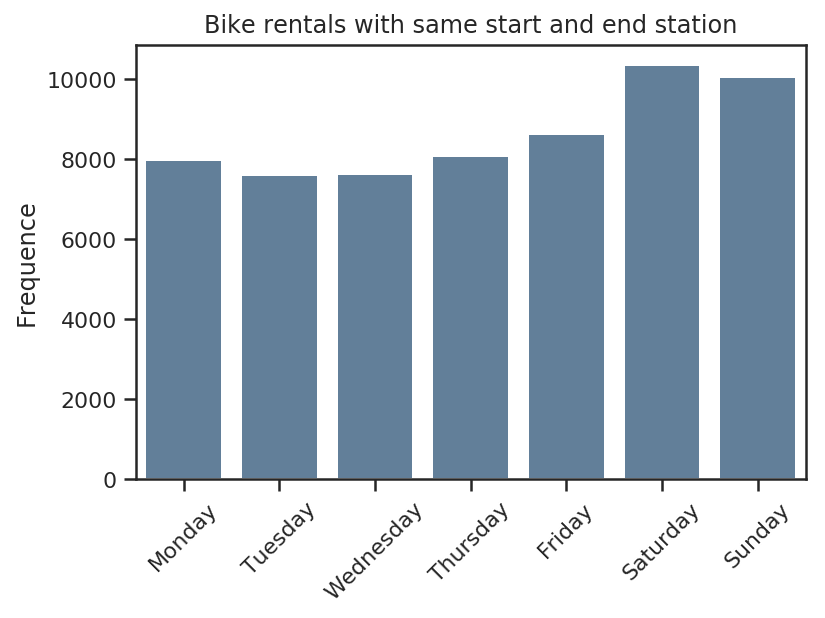

In [11]:
same_station = bikeshare_df[bikeshare_df.start_station_id == bikeshare_df.end_station_id].copy()

ax = sns.countplot(same_station.start_time.dt.weekday_name, 
                   order=weekday_names, 
                   color='steelblue', 
                   saturation=0.5)

ax.set(xlabel='', 
       ylabel='Frequence', 
       title='Bike rentals with same start and end station')
ax.tick_params(axis='x', 
               labelrotation=45)

The frequency of bike rentals is higher on weekends than in business weekdays.

### Does the user types have different bike rental behavior?

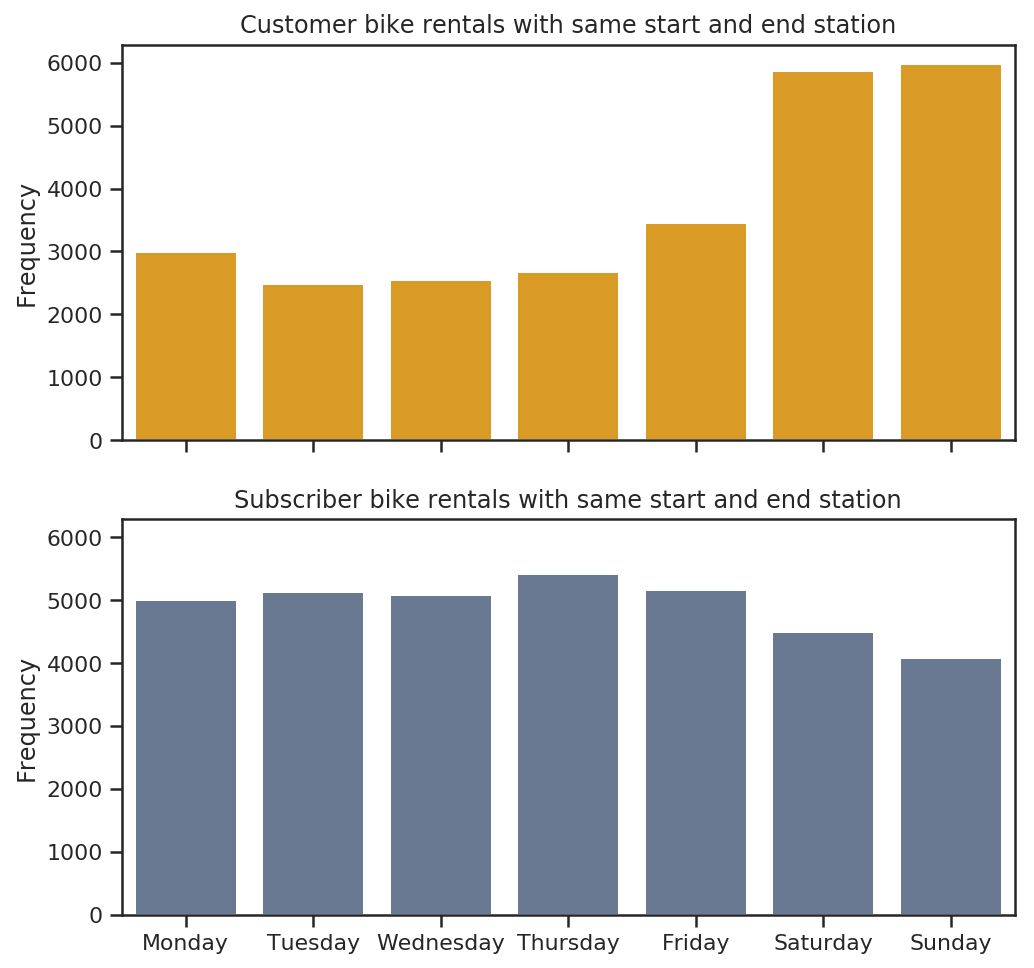

In [12]:
same_station['weekday'] = same_station.start_time.dt.weekday_name

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (8, 8))

sns.countplot(x='weekday', 
              data=same_station[same_station.user_type == 'Customer'], 
              order=weekday_names, 
              color='orange', 
              saturation=0.7, 
              ax=ax1)
ax1.set(xlabel='', ylabel='Frequency', title='Customer bike rentals with same start and end station')

sns.countplot(x='weekday', 
                   data=same_station[same_station.user_type == 'Subscriber'], 
                   order=weekday_names, 
                   color='b', 
                   saturation=0.4, 
                   ax=ax2)
ax2.set(xlabel='', ylabel='Frequency', title='Subscriber bike rentals with same start and end station');


When segmenting the bike trips on user type a different pattern is revealed for customers. They have a increase rental frequency on saturdays. Probably because it is weekend tourists visiting the San Francisco Bay area.



Bike rental trips that have the same start and end station seems to occur mostly on the weekend and the casual Customer user type is responsible for the incease

## Summary of Findings

Bike rentals mostly occurs on business weekdays with peek bike trips on tuesday, wednesday, and thursdays.
When segmenting the bike trips on user type a different pattern is revealed for customers. They have a increase rental frequency on saturdays.

I'm not able to explain why bike rental durations have several extreme values of hours and even days. But maybe this could be explained by bike getting flat tires,  other mechanical failures or even accidents? These questions can't be answered from the dataset.

## Key Insights for Presentation

The most common duration for a bike trips is less then 10 minutes.

Customer user type account for 14 % of bike rentals with an increase of rentals on saturdays. 
One explanation could be that the Customer user type consist of weekend tourists visiting the San Francisco Bay area.